In [1]:
## extention of "https://docs.astropy.org/en/stable/coordinates/frames.html"
import numpy as np
import pylab as pl
from sgp4.api import Satrec
from sgp4.api import SGP4_ERRORS
from astropy.coordinates import TEME, CartesianDifferential, CartesianRepresentation
from astropy import units as u
from astropy.time import Time, TimeDelta
from astropy.coordinates import ITRS
from astropy.coordinates import EarthLocation, AltAz

In [2]:
## create satellite object

s = '1 25544U 98067A   19343.69339541  .00001764  00000-0  38792-4 0  9991'
t = '2 25544  51.6439 211.2001 0007417  17.6667  85.6398 15.50103472202482'
satellite = Satrec.twoline2rv(s, t)
world = np.load('world.npy')

(<Figure size 1200x600 with 1 Axes>, <Axes: >)

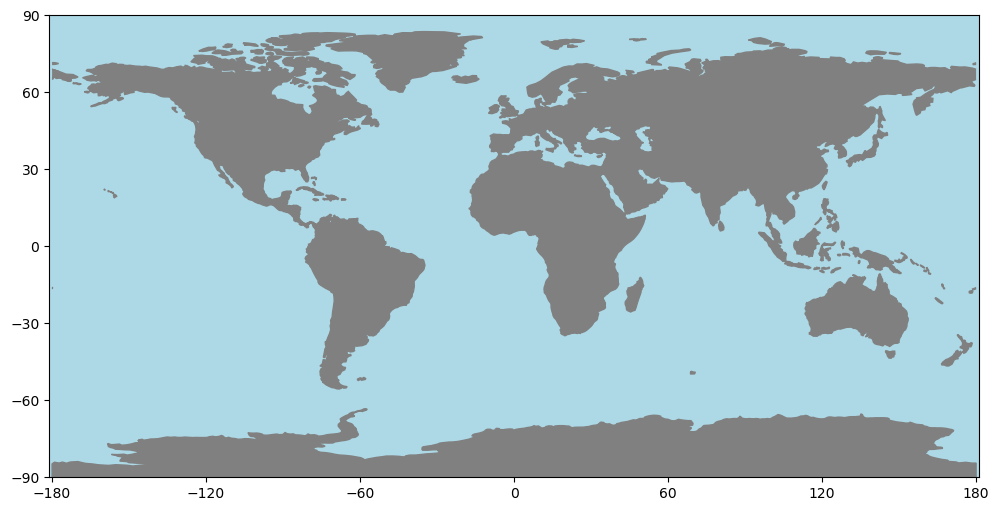

In [3]:
# simple map plotting routine

def plot_world_map():
    fig, ax = pl.subplots(1, figsize=(12, 6))
    ax.set_xticks(np.arange(-180, 181, 60))
    ax.set_yticks(np.arange(-90, 91, 30))
    antarctica = world[:,1] < -60
    ant = world[antarctica]
    start = np.argmin(ant[:,0])
    stop = np.argmax(ant[:,0])
    length = stop - start
    ant = np.roll(ant, -start, axis=0)[:length]
    ant = np.vstack([[-180, -90], ant, [180, ant[-1,1]], [180, -90]])
    rest = world[np.logical_not(antarctica)]
    w = np.vstack([rest, [np.nan, np.nan], ant])
    ax.set_facecolor('lightblue')

    ax.fill(w[:,0], w[:,1], color='grey', alpha=1)
    ax.axis('equal')
    ax.set_xlim(-180, 180)
    ax.set_ylim(-90, 90)
    return fig, ax
plot_world_map()

In [4]:
# grab a single TEME position and velocity

t = Time(2458827.362605, format='jd')
error_code, teme_p, teme_v = satellite.sgp4(t.jd1, t.jd2)  # in km and km/s
if error_code != 0:
    raise RuntimeError(SGP4_ERRORS[error_code])

teme_p = CartesianRepresentation(teme_p*u.km)
teme_v = CartesianDifferential(teme_v*u.km/u.s)
teme = TEME(teme_p.with_differentials(teme_v), obstime=t)

In [5]:
### convert to geodetic

itrs_geo = teme.transform_to(ITRS(obstime=t))
location = itrs_geo.earth_location
location.geodetic  

siding_spring = EarthLocation.of_site('aao')  
topo_itrs_repr = itrs_geo.cartesian.without_differentials() - siding_spring.get_itrs(t).cartesian
itrs_topo = ITRS(topo_itrs_repr, obstime = t, location=siding_spring)
aa = itrs_topo.transform_to(AltAz(obstime=t, location=siding_spring))
print(aa.alt, aa.az) 

10d56m52.78793904s 59d17m16.92201911s


In [6]:
times = [Time(2458827.362605 + i/86400., format='jd') for i in range(3600 * 5)]
jd = np.array([(t.jd1, t.jd2) for t in times])

In [7]:
ephem = np.array([satellite.sgp4(t.jd1, t.jd2)[1:] for t in times]) 

In [8]:
ephem.shape

(18000, 2, 3)

In [9]:
ephem = ephem.reshape((-1, 6))
ephem.shape

(18000, 6)

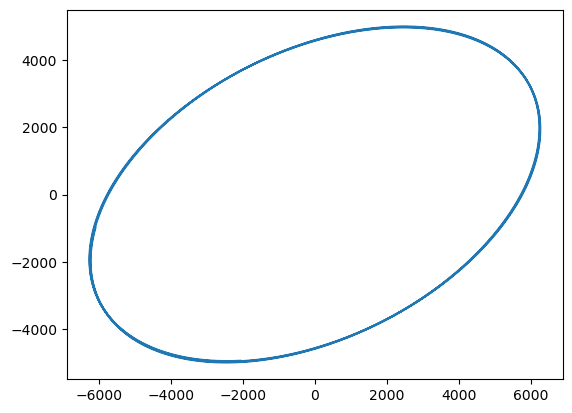

In [10]:
pl.figure()
pl.plot(ephem[:,0], ephem[:,1])

In [11]:
sidereal_day = 23 * 3600 + 56 * 60 + 4.09
DEG = np.pi / 180
omega = 2 * np.pi/ sidereal_day
theta = omega * np.arange(86400)
theta / DEG

array([0.00000000e+00, 4.17807465e-03, 8.35614930e-03, ...,
       3.60973115e+02, 3.60977293e+02, 3.60981472e+02])

In [12]:
cost = np.cos(theta)
sint = np.sin(theta)
R = np.zeros((86400, 3, 3))
R[:,2,2] = 1
R[:,0,0] = cost
R[:,1,1] = cost
R[:,0,1] = -sint
R[:,1,0] =  sint


In [13]:
ephem_ecf = np.array([np.hstack([r @ e[:3], r @ e[3:]]) for r, e in zip(R, ephem)])
x = ephem_ecf[:,0]
y = ephem_ecf[:,1]
z = ephem_ecf[:,2]
sat_lon = np.arctan2(y, x)
sat_lat = np.arctan2(z, np.sqrt(x ** 2 + y ** 2))

(-90.0, 90.0)

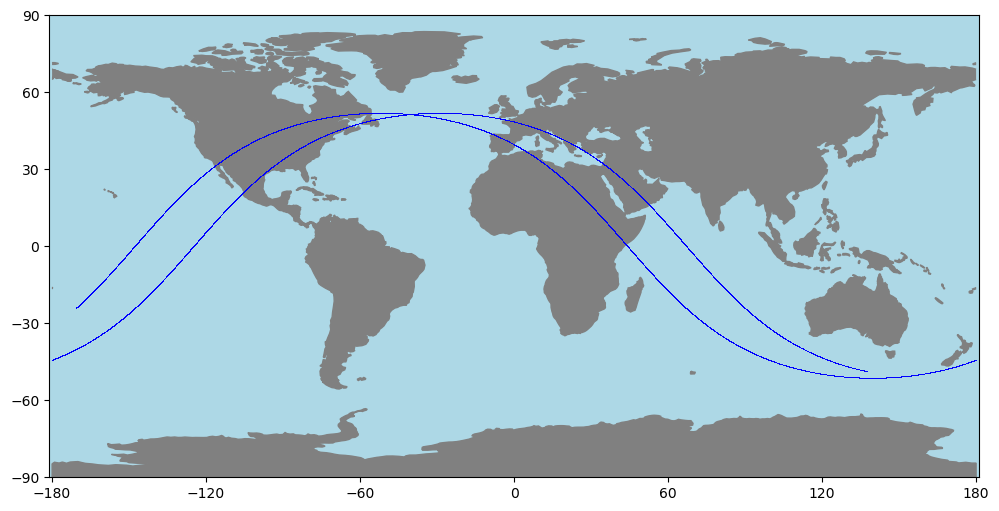

In [14]:
fig, ax = plot_world_map()
ax.plot(sat_lon[:10000] / DEG, sat_lat[:10000] / DEG, 'b,')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)


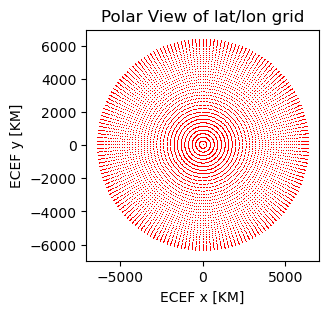

In [15]:
_lat = np.linspace(-90, 90, 91) * DEG
_lon = np.linspace(-180, 180, 181) * DEG
EARTH_RADIUS = 6378.137

grid_lat, grid_lon = np.meshgrid(_lat, _lon)
grid_lat = grid_lat.ravel()
grid_lon = grid_lon.ravel()
gx = EARTH_RADIUS * np.cos(grid_lat) * np.cos(grid_lon)
gy = EARTH_RADIUS * np.cos(grid_lat) * np.sin(grid_lon)
gz = EARTH_RADIUS * np.sin(grid_lat)
g_ecf = np.column_stack([gx, gy, gz])
up = g_ecf / EARTH_RADIUS
pl.figure(figsize=(3, 3))
pl.plot(gx, gy, 'r,')
pl.axis('equal')
pl.xlabel('ECEF x [KM]')
pl.ylabel('ECEF y [KM]')
j = pl.title("Polar View of lat/lon grid")

In [16]:
def visibility(ephem_ecf, g):
    g = np.array(g)
    doa = (g - ephem_ecf[:,:3])
    inview = -doa @ g > 0
    return inview
def coverage(ephem_ecf, g, dt):
    inview = visibility(ephem_ecf, g)
    return sum(inview) * dt

earth_lat = 39 * DEG
earth_lon = -77 * DEG
#earth_lat = -23 * DEG
#earth_lon = -170 * DEG
g = EARTH_RADIUS * np.array([np.cos(earth_lat) * np.cos(earth_lon), 
                             np.cos(earth_lat) * np.sin(earth_lon),
                             np.sin(earth_lat)])

v = visibility(ephem_ecf, g)
print(g)
__lat = np.arctan2(np.sum(g[:2] ** 2), g[2])
print('g', g)

[ 1115.02465645 -4829.70239866  4013.89167101]
g [ 1115.02465645 -4829.70239866  4013.89167101]


(-90.0, 90.0)

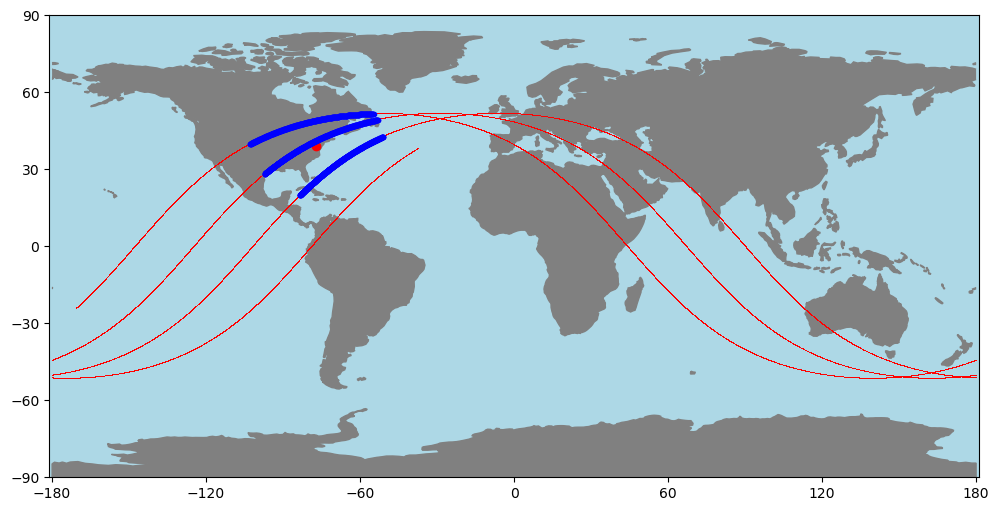

In [17]:
fig, ax = plot_world_map()
ax.plot(earth_lon / DEG, earth_lat / DEG, 'ro')
j = ax.plot(sat_lon / DEG, sat_lat / DEG, 'r,')
j = ax.plot(sat_lon[v] / DEG, sat_lat[v] / DEG, 'b.')
j = ax.axis('equal')
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

In [18]:
## compute coverage for a few points to save time
cov = np.array([coverage(ephem_ecf, g, 1.) for g in g_ecf])

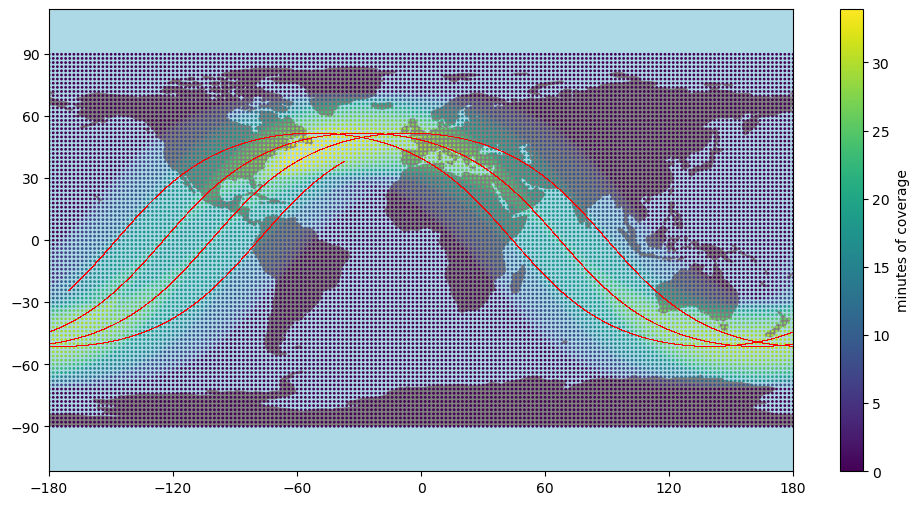

In [19]:
fig, ax = plot_world_map()
mappable = ax.scatter(grid_lon / DEG, grid_lat / DEG, c=cov/60, s=1, marker='o')
j = ax.plot(sat_lon / DEG, sat_lat / DEG, 'r,')
fig.colorbar(mappable=mappable, label='minutes of coverage')

In [20]:
#np.savez('coverage.npy', grid_lat=grid_lat, grid_lon=grid_lon, coverage=cov)